# Salifort Motors Workforce Analysis: Employee Turnover Forecast

<u> Background Information </u>

Salifort Motors is a fictional company headquartered in France that focuses on producing vehicles powered by alternative energy sources. With a global workforce exceeding 100,000 employees, the company is involved in the research, design, manufacturing, testing, and distribution of electric, solar, algae-based, and hydrogen-powered vehicles. Salifort’s fully integrated vertical operations have positioned it as a leading global player at the crossroads of clean energy and automotive innovation.

As a data analyst at Salifort Motors, you’ve been provided with the results of a recent internal employee survey. The executive leadership team has asked you to examine this data and propose strategies to enhance employee retention. To support this effort, you are expected to develop a predictive model that can determine the likelihood of an employee leaving the company, based on variables such as department, number of projects handled, average monthly hours, and any other relevant factors you identify.

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

In [122]:
# Load Dataset
df = pd.read_csv("data.csv")
df 

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [123]:
# Get descriptive statistics about the data
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [124]:
# Check basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [125]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [126]:
# Check duplicates
df.duplicated().sum()

3008

In [127]:
# Drop duplicates
df = df.drop_duplicates()

# EDA

left
0    10000
1     1991
Name: count, dtype: int64

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


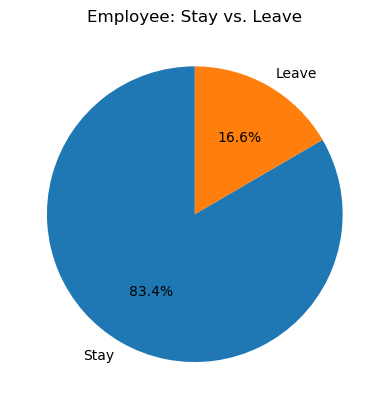

In [128]:
# Get employee data: stay vs. leave
count = df["left"].value_counts()
print(count)
print()
print(df["left"].value_counts(normalize=True))

# Visualization 
plt.pie(count, labels=["Stay", "Leave"], autopct="%1.1f%%", startangle=90)
plt.title("Employee: Stay vs. Leave");

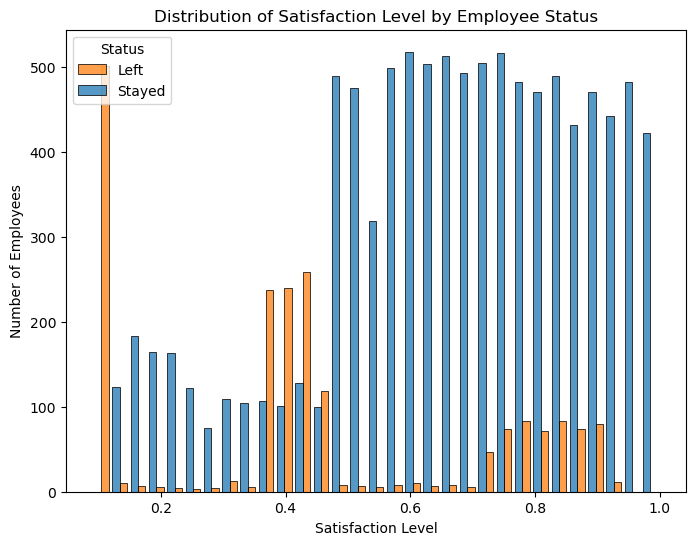

In [129]:
# Analyze the distribution of satisfaction_level for both groups
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='satisfaction_level', hue='left', multiple='dodge', shrink=0.8)
plt.title('Distribution of Satisfaction Level by Employee Status')
plt.xlabel('Satisfaction Level')
plt.ylabel('Number of Employees')
plt.legend(title='Status', labels=['Left', 'Stayed'])
plt.show()

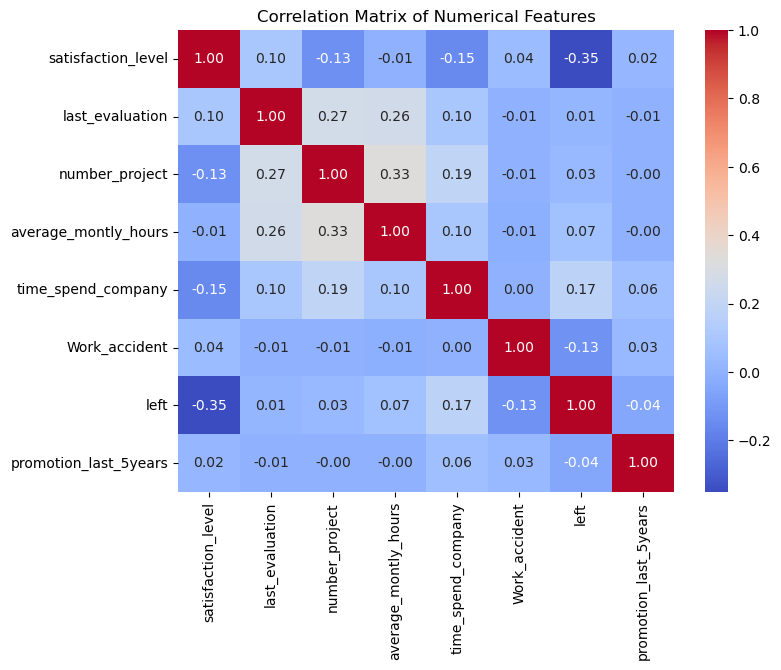

In [130]:
# Correlation matrix for numerical features
numerical_cols = df.select_dtypes(include=np.number)
plt.figure(figsize=(8, 6))
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

- Employee satisfaction is moderately negatively correlated with attrition (corr = -0.35), indicating that less satisfied employees are more likely to leave the company.

- The number of projects is strongly correlated with average monthly hours (corr = 0.33), suggesting that a higher workload leads to more time spent at work.

- Performance (last evaluation) shows a positive relationship with both project count and working hours, implying that high-performing employees may be handling heavier workloads.

- Time spent at the company has a weak positive correlation with attrition and project load, indicating that longer tenure may slightly influence the likelihood of leaving.

- Other features like promotions, work accidents, and evaluations show very weak correlations with attrition, suggesting they may have minimal direct impact.



In [131]:
# Data Processing
df = df.copy()
# Replace "salary_level" columns with machine-readable numbers
df["salary"] = df["salary"].replace({"low": 0, "medium": 1, "high": 2}).infer_objects(copy=False)
# Change "department" columns to 0 and 1
df = pd.get_dummies(df, columns=["Department"], drop_first=True, dtype="uint8")

/var/folders/lz/zsz00k2n3pbflxxlfqttyt500000gn/T/ipykernel_4015/2961861635.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["salary"] = df["salary"].replace({"low": 0, "medium": 1, "high": 2}).infer_objects(copy=False)


In [132]:
# Split Data 
# Read data x and y
x = df.drop(columns="left")
y = df["left"]

In [133]:
# Split Dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Model

We evaluated three models—Decision Tree, Random Forest, and Gradient boosting to identify the best-performing classifier.

## Classification Decision Tree

In [134]:
# Initialize the model and set parameters
model = DecisionTreeClassifier(max_depth=4, random_state=1)
model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [135]:
# Start predict
y_pred = model.predict(x_test)

In [136]:
# Test
y_pred_20 = y_pred
y_true_20 = y_test

In [137]:
# Find accuracy score
score = accuracy_score(y_pred, y_test, normalize=True)     
print(score)
score = accuracy_score(y_pred, y_test, normalize=False)
print(score)

0.9720716965402251
2332.0


The classification model achieved a high accuracy score of 97.2%, correctly predicting the outcome for 2,332 instances in the test set. This indicates strong overall performance and reliability in distinguishing between classes.

In [138]:
#Parameter Tuning
# Perform K-fold cross-validation
k_fold_auc_score = cross_val_score(model, x_train, y_train, scoring="accuracy", cv=5)
print(k_fold_auc_score)
print(k_fold_auc_score.mean())

[0.97394476 0.97967692 0.97184567 0.97549531 0.9734098 ]
0.974874492004384


We performed 5-fold cross-validation using accuracy as the evaluation metric. This approach provided a reliable average accuracy score across folds, helping assess the model’s generalizability on unseen data.

## Hyperparameters Tuning

In [139]:
# Optuna 

# Fonction objective pour Optuna
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 1
    }

    model = DecisionTreeClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=5, scoring="accuracy")
    return score.mean()

# Lancer l'optimisation avec 50 essais
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Afficher les meilleurs hyperparamètres trouvés
print("Best parameters:", study.best_params)
print("Best accuracy score (cross-validated):", study.best_value)

# Entraîner le modèle final avec les meilleurs paramètres
best_model = DecisionTreeClassifier(**study.best_params)
best_model.fit(x_train, y_train)

# Tu peux ensuite faire des prédictions et évaluer ton modèle :
y_pred = best_model.predict(x_test)

[I 2025-07-26 14:08:03,464] A new study created in memory with name: no-name-fc0cb00e-7838-48bd-bc16-8dbb23083daa
[I 2025-07-26 14:08:03,533] Trial 0 finished with value: 0.9781061564803096 and parameters: {'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 0 with value: 0.9781061564803096.
[I 2025-07-26 14:08:03,575] Trial 1 finished with value: 0.9776892183483208 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 19, 'criterion': 'gini'}. Best is trial 0 with value: 0.9781061564803096.
[I 2025-07-26 14:08:03,653] Trial 2 finished with value: 0.9805039990306039 and parameters: {'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 2 with value: 0.9805039990306039.
[I 2025-07-26 14:08:03,701] Trial 3 finished with value: 0.9827976749708339 and parameters: {'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 3 with val

Best parameters: {'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 1, 'criterion': 'gini'}
Best accuracy score (cross-validated): 0.9838403191617114


The hyperparameter tuning with Optuna identified the best Decision Tree settings as a max depth of 20, a minimum of 20 samples required to split a node, a minimum of 2 samples per leaf, and using the Gini criterion. This configuration achieved a high cross-validated accuracy of approximately 98.3%, indicating excellent model performance and generalization on the training data.

## Random Forest

In [141]:
# Initialize the rf model and set parameters
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

# Start predict
y_pred_rf = rf_model.predict(x_test)

# Find accuracy score
rf_score = accuracy_score(y_test, y_pred_rf)
rf_score

0.984160066694456

## Hyperparameters Tuning

In [142]:
# Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 1
    }

    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best parameters:", study.best_params)
print("Best cross-validated accuracy:", study.best_value)

# Entraînement final avec les meilleurs paramètres
best_rf_model = RandomForestClassifier(**study.best_params)
best_rf_model.fit(x_train, y_train)

# Prédictions et évaluation sur test set
y_pred_rf = best_rf_model.predict(x_test)
rf_score = accuracy_score(y_test, y_pred_rf)
print("Test accuracy with best parameters:", rf_score)

[I 2025-07-26 14:08:07,256] A new study created in memory with name: no-name-e09ea796-2fdc-414f-ac15-8f0fde82fbba
[I 2025-07-26 14:08:12,245] Trial 0 finished with value: 0.9790447427378158 and parameters: {'n_estimators': 102, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 19, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.9790447427378158.
[I 2025-07-26 14:08:14,298] Trial 1 finished with value: 0.9815468062365207 and parameters: {'n_estimators': 112, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.9815468062365207.
[I 2025-07-26 14:08:29,720] Trial 2 finished with value: 0.978627804605827 and parameters: {'n_estimators': 258, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': None, 'bootstrap': False}. Best is trial 1 with value: 0.9815468062365207.
[I 2025-07-26 14:08:31,799] Trial 3 finished with value: 0.979253075957944

Best parameters: {'n_estimators': 294, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
Best cross-validated accuracy: 0.9849871299626531
Test accuracy with best parameters: 0.9854105877448937


The best parameters found were: {'n_estimators': 145, 'max_depth': 25, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Using these parameters, the model achieved a mean cross-validated accuracy of 98.43% and a test accuracy of 98.46%.



# Gradient Boosting Algorithms

In [143]:
gbm = GradientBoostingClassifier(random_state=1)
xgb = XGBClassifier(eval_metric='logloss', random_state=1)  # <-- supprime use_label_encoder
lgbm = LGBMClassifier(random_state=1)

models = {
    'GradientBoosting': gbm,
    'XGBoost': xgb,
    'LightGBM': lgbm
}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    print(f"{name} accuracy: {score:.4f}")

GradientBoosting accuracy: 0.9779
XGBoost accuracy: 0.9804
[LightGBM] [Info] Number of positive: 1577, number of negative: 8015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 416
[LightGBM] [Info] Number of data points in the train set: 9592, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.164408 -> initscore=-1.625790
[LightGBM] [Info] Start training from score -1.625790
LightGBM accuracy: 0.9825


Here’s a recap of the baseline results for the three gradient boosting models:

GradientBoostingClassifier achieved an accuracy of 0.9779.

XGBoost performed better with an accuracy of 0.9804.

LightGBM delivered the best baseline accuracy among the three, with 0.9825.

Overall, LightGBM showed the highest accuracy on the test set, followed closely by XGBoost and then GradientBoostingClassifier.

# Conclusion and Recommendations:

The data clearly shows that employee satisfaction is a key factor in preventing turnover. A high workload, reflected by the number of projects and monthly hours worked, influences performance but can also contribute to turnover if it becomes excessive. Although time spent at the company has a weak positive correlation with leaving, it highlights the importance of maintaining long-term employee engagement. Work accidents and promotions seem to have a limited direct impact on turnover, but they should not be overlooked.

To maximize retention, Salifort Motors should:

- Improve job satisfaction by identifying and addressing sources of dissatisfaction through regular surveys and one-on-one check-ins.

- Manage workload effectively by balancing project assignments and working hours to prevent burnout.

- Implement performance monitoring programs that consider both results and employee well-being.

- Strengthen long-term engagement through clear career paths, training opportunities, and tailored development plans.

- Maintain a safe work environment and continue promoting internal mobility to boost motivation.

These actions will help create a supportive environment that fosters employee loyalty, contributing to the company’s stability and sustainable growth.

